Starting simulation...


Time Steps: 100%|██████████| 80/80 [04:04<00:00,  3.06s/it]


Total runtime: 244.98 seconds


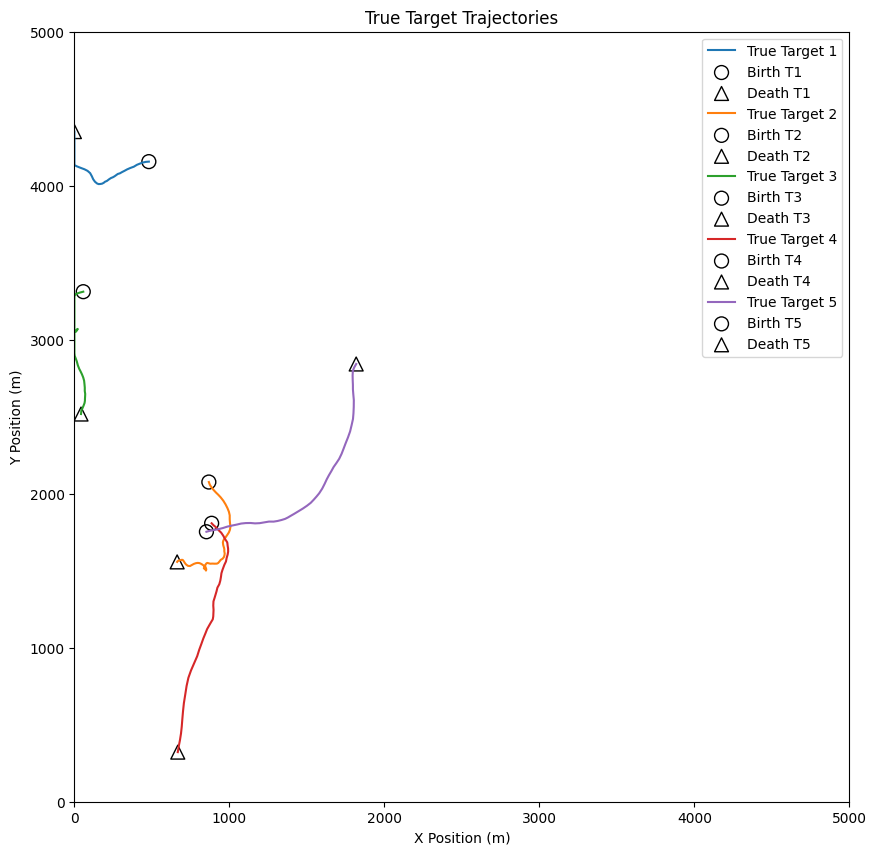

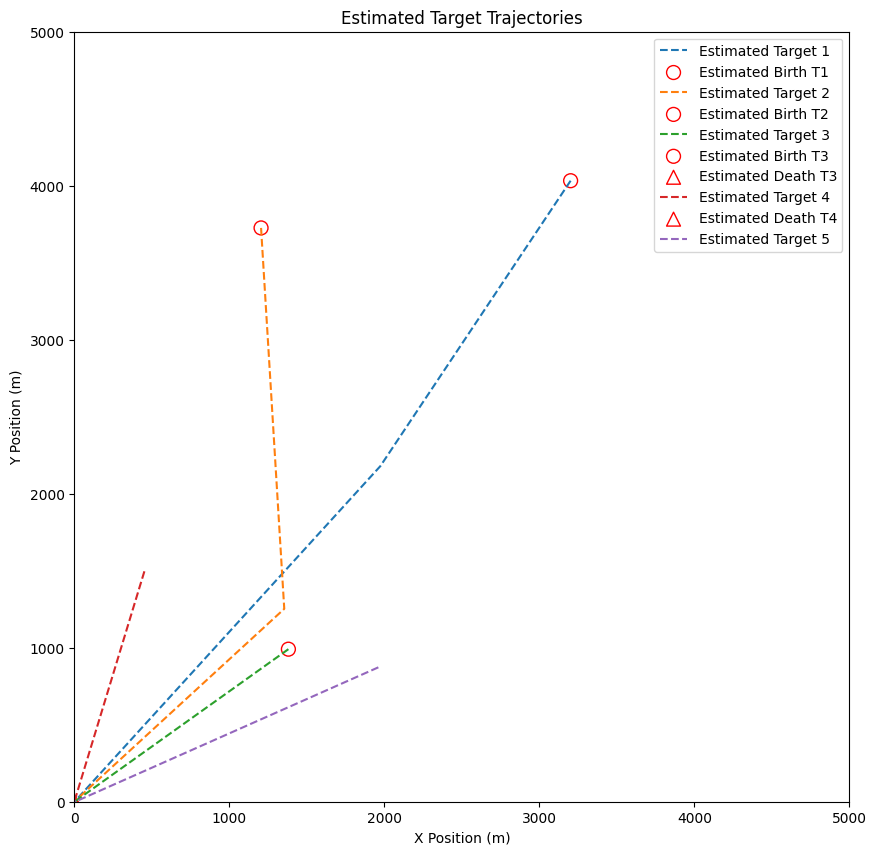

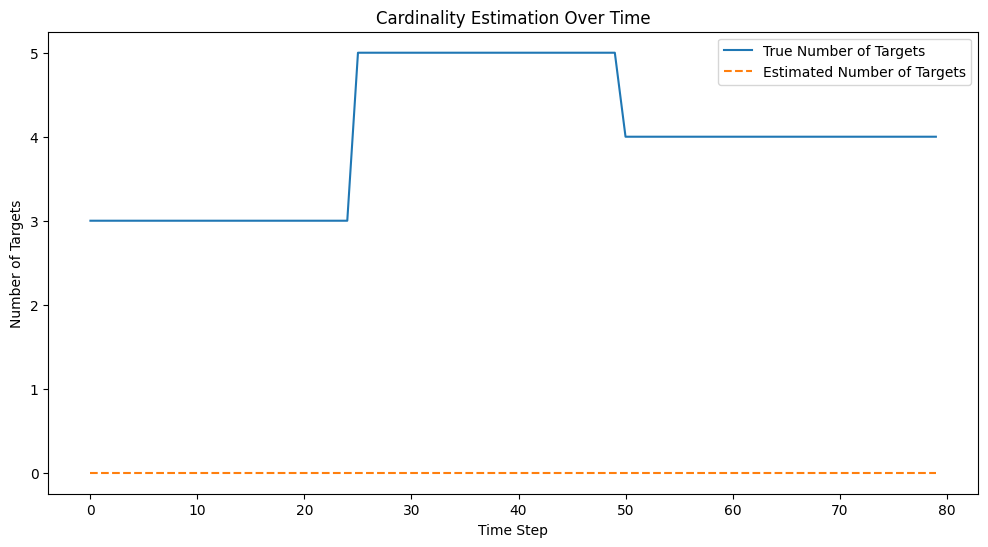

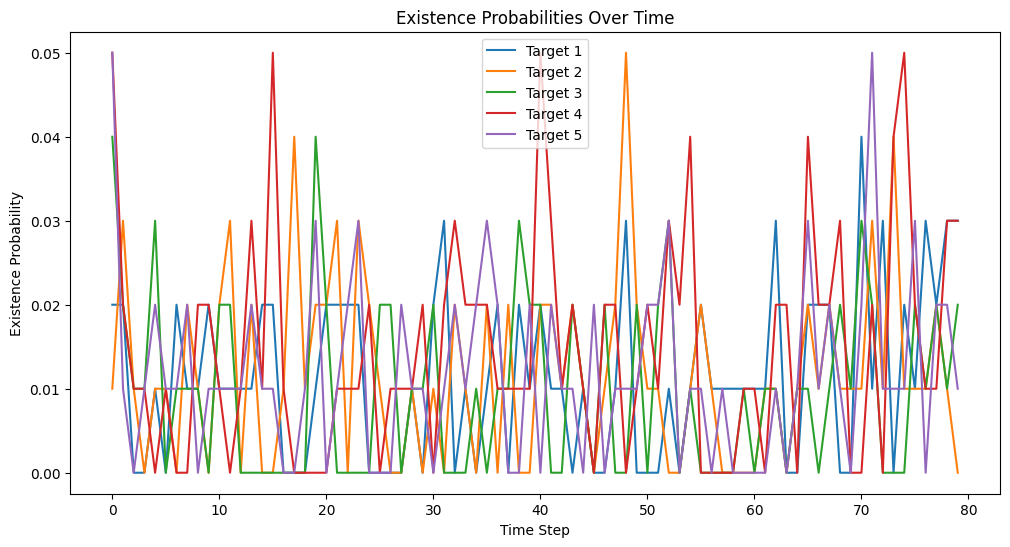

RMSE over all time steps and targets: 2643.90 meters
Existence Probability RMSE: 0.88


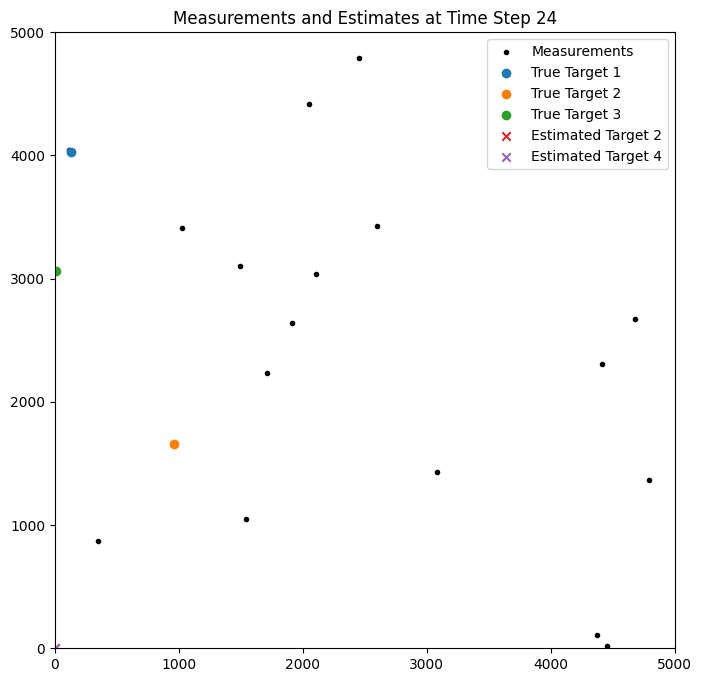

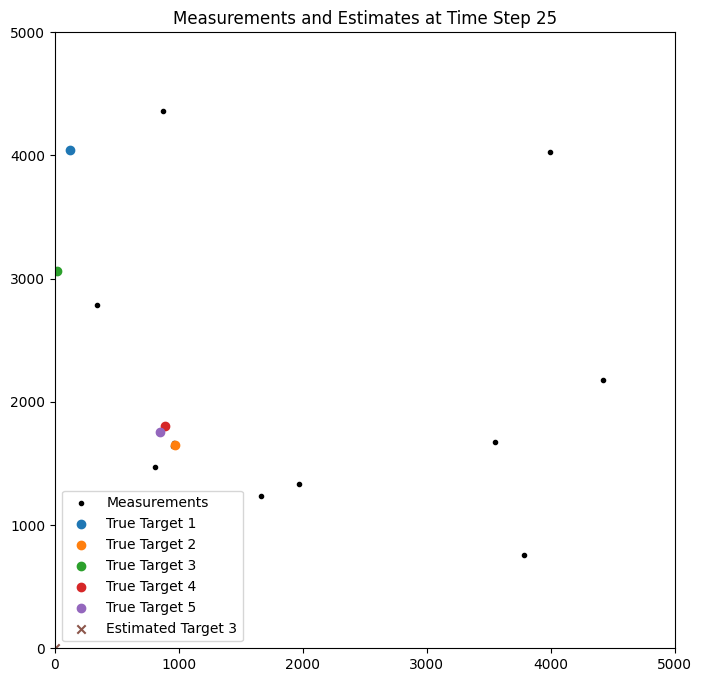

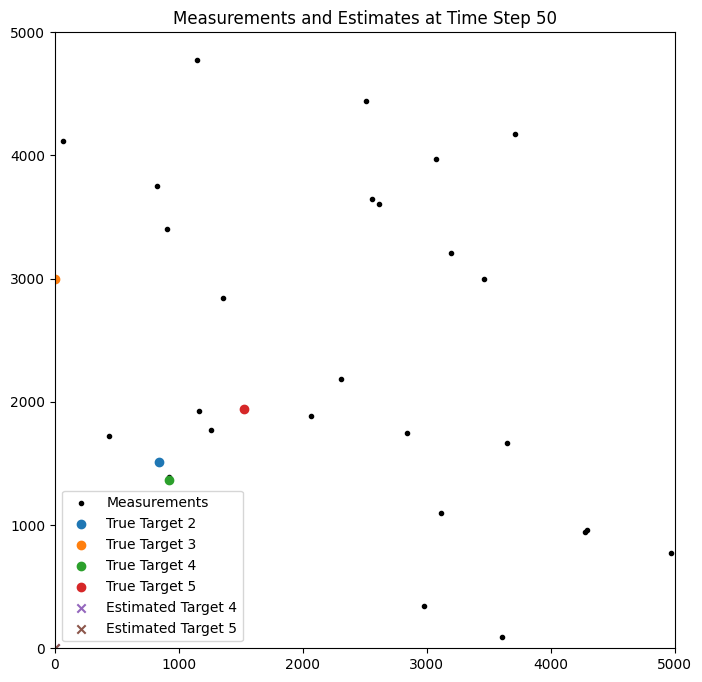

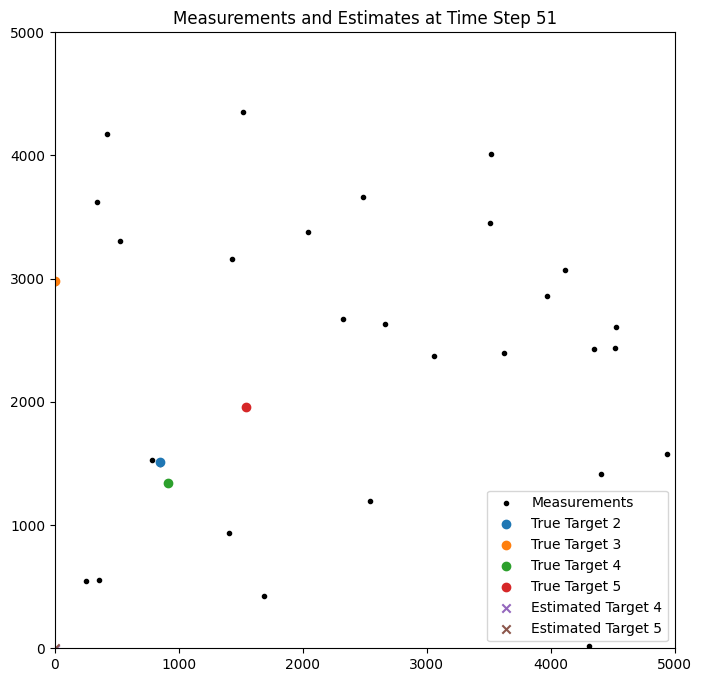

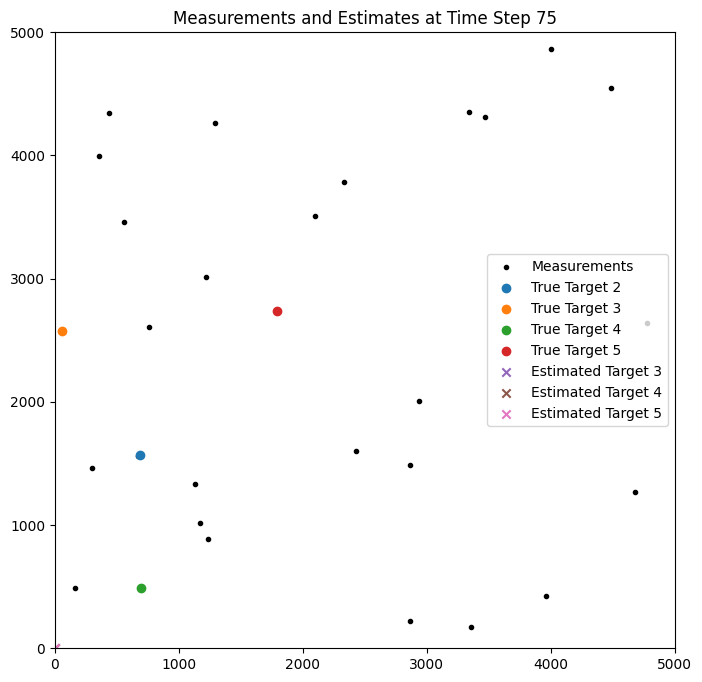

Total runtime: 244.98 seconds


In [27]:
# Import necessary libraries
import numpy as np
from scipy.stats import multivariate_normal, poisson
import matplotlib.pyplot as plt
import time
from tqdm import tqdm  # Library for progress bars

# =========================
# 1. Simulation Parameters
# =========================

# Surveillance area dimensions
L_x = 5000.0  # Width in meters
L_y = 5000.0  # Height in meters

# Time parameters
T = 80.0               # Total simulation time in seconds
delta_t = 1.0           # Time step in seconds
K = int(T / delta_t)    # Total number of time steps
time_vector = [k * delta_t for k in range(K)]
tau = 3

# Maximum number of potential targets
N_max = 5

# Target birth and death schedule
# Each tuple: (birth_time_step, death_time_step)
target_schedule = [
    (0, 50),      # Target 1: born at time step 0, dies at time step 50
    (0, K),        # Target 2: born at time step 0, never dies within simulation
    (0, K),        # Target 3: born at time step 0, never dies within simulation
    (25, K),       # Target 4: born at time step 25, never dies within simulation
    (25, K),       # Target 5: born at time step 25, never dies within simulation
]

# Motion model parameters
sigma_process = np.sqrt(0.5)  # Standard deviation of the process noise
V_max = 10.0         # Maximum target velocity in m/s

# Sensor model parameters
sigma_measurement = 10.0  # Standard deviation of measurement noise
R = sigma_measurement ** 2 * np.eye(2)  # Measurement noise covariance matrix

# Clutter model parameters
Lambda_C = 20  # Average number of clutter measurements per time step
Lambda_x = 1   # Mean number of detections per target per time step

# Transition probabilities for existence variables
P_S = 0.9  # Probability that an active target survives
P_B = 0.1  # Probability that a new target is born

# Initialize process noise covariance matrix Q
def get_process_noise_covariance(tau, sigma_process):
    Q = sigma_process ** 2 * np.array([
        [tau ** 3 / 3, 0, tau ** 2 / 2, 0],
        [0, tau ** 3 / 3, 0, tau ** 2 / 2],
        [tau ** 2 / 2, 0, tau, 0],
        [0, tau ** 2 / 2, 0, tau]
    ])
    return Q

Q = get_process_noise_covariance(tau, sigma_process)

# State transition matrix A
A = np.array([
    [1, 0, tau, 0],
    [0, 1, 0, tau],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

# Predefined death state
x_death = np.array([0, 0, 0, 0])

# =========================
# 2. Helper Functions
# =========================

# Function to initialize target state upon birth
def initialize_target_state():
    position = np.array([
        np.random.uniform(0, L_x),  # x position
        np.random.uniform(0, L_y)   # y position
    ])
    velocity = np.array([
        np.random.uniform(-V_max, V_max),  # x velocity
        np.random.uniform(-V_max, V_max)   # y velocity
    ])
    return np.concatenate((position, velocity))

# Function to update true targets
def update_true_targets(k, target_states, existence_flags, target_schedule):
    for n in range(N_max):
        birth_time, death_time = target_schedule[n]
        if birth_time <= k < death_time:
            # Target is active
            if existence_flags[n] == 0:
                # Target is born, initialize state
                target_states[n] = initialize_target_state()
            existence_flags[n] = 1
            # Move target using motion model
            process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
            target_states[n] = A @ target_states[n] + process_noise
            # Ensure target stays within surveillance area
            target_states[n][0] = np.clip(target_states[n][0], 0, L_x)
            target_states[n][1] = np.clip(target_states[n][1], 0, L_y)
        else:
            # Target is inactive
            existence_flags[n] = 0

# Function to generate clutter measurements
def generate_clutter_measurements():
    num_clutter = np.random.poisson(Lambda_C)
    clutter_measurements = np.random.uniform(
        [0, 0],
        [L_x, L_y],
        size=(num_clutter, 2)
    )
    return clutter_measurements

# Function to generate measurements
def generate_measurements(target_states, existence_flags):
    measurements = []
    # Generate target-originated measurements
    for n in range(N_max):
        if existence_flags[n]:
            # Target is active
            position = target_states[n][:2]
            num_measurements_alive = np.random.poisson(Lambda_x)  # Number of measurements from this target
            for _ in range(num_measurements_alive):
                measurement_noise = np.random.multivariate_normal(
                    mean=[0, 0],
                    cov=R
                )
                measurement = position + measurement_noise
                measurements.append(measurement)
    # Generate clutter measurements
    clutter_measurements = generate_clutter_measurements()
    if clutter_measurements.size > 0:
        measurements.extend(clutter_measurements)
    return np.array(measurements)

# Function to propose existence variable
def propose_existence(ekn_prev):
    if ekn_prev == 1:
        # Target may survive or die
        ekn_star = np.random.choice([1, 0], p=[P_S, 1 - P_S])
    else:
        # Target may be born or remain absent
        ekn_star = np.random.choice([1, 0], p=[P_B, 1 - P_B])
    return ekn_star

# Function to sample from motion model
def motion_model_sample(x_prev):
    process_noise = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    x_new = A @ x_prev + process_noise
    return x_new

def compute_log_likelihood(measurements_k, xk, ek):
    """
    Calcule la log-vraisemblance des mesures observées donné les états des cibles et leurs existences.
    If measurements_k is None, return 0.0 to skip measurement-based likelihood.
    """
    # ---- Minimal Fix Start ----
    if measurements_k is None:
        return 0.0
    # ---- Minimal Fix End ----

    num_targets = np.sum(ek)
    mu_k = Lambda_C + num_targets * Lambda_x
    M_k = len(measurements_k)
    
    log_poisson = poisson.logpmf(M_k, mu_k)
    sum_log_intensity = 0.0
    for z in measurements_k:
        clutter_intensity = Lambda_C / (L_x * L_y)
        target_intensity = 0.0
        for n in range(N_max):
            if ek[n] == 1:
                target_intensity += multivariate_normal.pdf(z, mean=xk[n][:2], cov=R)
        lambda_z = clutter_intensity + target_intensity
        if lambda_z <= 0:
            lambda_z = 1e-300
        sum_log_intensity += np.log(lambda_z)
    return log_poisson + sum_log_intensity

# Function to compute log target density
def compute_log_target_density(xk, ek, xk_prev, ek_prev, measurements_k):
    # Compute log likelihood of measurements given current states and existences
    log_likelihood = compute_log_likelihood(measurements_k, xk, ek)
    
    # Compute log prior based on existence transitions and state transitions
    log_prior = 0.0
    for n in range(N_max):
        ekn = ek[n]
        ekn_prev = ek_prev[n]
        # Existence transition probability
        if ekn_prev == 1:
            if ekn == 1:
                log_p_e = np.log(P_S)
            else:
                log_p_e = np.log(1 - P_S)
        else:
            if ekn == 1:
                log_p_e = np.log(P_B)
            else:
                log_p_e = np.log(1 - P_B)
        # State transition probability
        if ekn == 1:
            if ekn_prev == 1:
                mean = A @ xk_prev[n]
                cov = Q
                log_p_x = multivariate_normal.logpdf(xk[n], mean=mean, cov=cov)
            else:
                # Uniform prior for newly born target
                volume = L_x * L_y * (2 * V_max) ** 2
                log_p_x = -np.log(volume)
        else:
            # Inactive targets have no state probability contribution
            log_p_x = 0.0
        log_prior += (log_p_e + log_p_x)
    
    # Total log target density
    return log_likelihood + log_prior

# =========================
# Proposal Distributions q1, q2, q3
# =========================

def q1_joint_proposal(xk_current, ek_current, xk_prev_current, ek_prev_current):
    """
    Joint proposal for {xk*, ek*, xk-1*, ek-1*} ~ q1(...)
    """
    xk_star = np.zeros_like(xk_current)
    ek_star = np.zeros_like(ek_current)
    xk_prev_star = xk_prev_current.copy()
    ek_prev_star = ek_prev_current.copy()
    
    # Propose new {xk-1*, ek-1*}
    for n in range(N_max):
        if np.random.rand() < 0.05:
            ek_prev_star[n] = 1 - ek_prev_star[n]
        if ek_prev_star[n] == 1:
            xk_prev_star[n] = xk_prev_star[n] + 0.05 * np.random.randn(4)
        else:
            xk_prev_star[n] = x_death.copy()
    
    # Propose new {xk*, ek*} based on proposed {xk-1*, ek-1*}
    for n in range(N_max):
        ekn_star = propose_existence(ek_prev_star[n])
        ek_star[n] = ekn_star
        if ekn_star == 1:
            if ek_prev_star[n] == 1:
                xk_star[n] = motion_model_sample(xk_prev_star[n])
            else:
                xk_star[n] = initialize_target_state()
        else:
            xk_star[n] = x_death.copy()
    
    return xk_star, ek_star, xk_prev_star, ek_prev_star

def q2_refine_prev(xk_current, ek_current, xk_prev_current, ek_prev_current):
    """
    Refinement proposal for {xk-1*, ek-1*} ~ q2(...)
    """
    xk_prev_star = xk_prev_current.copy()
    ek_prev_star = ek_prev_current.copy()
    
    for n in range(N_max):
        if np.random.rand() < 0.05:
            ek_prev_star[n] = 1 - ek_prev_star[n]
        if ek_prev_star[n] == 1:
            xk_prev_star[n] = xk_prev_star[n] + 0.05 * np.random.randn(4)
        else:
            xk_prev_star[n] = x_death.copy()
    
    return xk_prev_star, ek_prev_star

def q3_refine_curr(xk_current, ek_current, xk_prev_current, ek_prev_current, measurements_k):
    """
    Refinement proposal for {xk*, ek*} ~ q3(...)
    """
    xk_star = xk_current.copy()
    ek_star = ek_current.copy()
    
    for n in range(N_max):
        ekn_prev = ek_prev_current[n]
        ekn_prop = propose_existence(ekn_prev)
        
        if ekn_prop == 1:
            if ekn_prev == 1:
                xkn_prop = motion_model_sample(xk_prev_current[n])
            else:
                xkn_prop = initialize_target_state()
        else:
            xkn_prop = x_death.copy()
        
        # Build trial states
        xk_trial = xk_star.copy()
        ek_trial = ek_star.copy()
        xk_trial[n] = xkn_prop
        ek_trial[n] = ekn_prop
        
        # Compute log target densities
        log_p_star = compute_log_target_density(xk_trial, ek_trial, xk_prev_current, ek_prev_current, measurements_k)
        log_p_current = compute_log_target_density(xk_star, ek_star, xk_prev_current, ek_prev_current, measurements_k)
        
        # Compute acceptance probability
        log_alpha = log_p_star - log_p_current
        
        # Accept or reject the proposal
        if np.log(np.random.rand()) < log_alpha:
            xk_star = xk_trial.copy()
            ek_star = ek_trial.copy()
    
    return xk_star, ek_star

# =========================
# 3. Initialization
# =========================

# Initialize true target states and existence flags
target_states = [np.zeros(4) for _ in range(N_max)]  # State: [x, y, vx, vy]
existence_flags = [0 for _ in range(N_max)]          # Existence flag: 0 (inactive), 1 (active)
target_trajectories = [[] for _ in range(N_max)]     # Store true trajectories
measurements_history = []                            # Store measurements at each time step

# Initialize particles
N_p = 100  # Number of particles
particles = []
for _ in range(N_p):
    x_init = np.array([initialize_target_state() if np.random.rand() < P_B else x_death.copy() for _ in range(N_max)])
    e_init = np.array([1 if not np.array_equal(x_init[i], x_death) else 0 for i in range(N_max)], dtype=int)
    particle = {
        'x_k': x_init.copy(),      # Current state
        'e_k': e_init.copy(),      # Current existence flags
        'x_k_prev': x_init.copy(), # Previous state
        'e_k_prev': e_init.copy(), # Previous existence flags
    }
    particles.append(particle)

# Initialize lists to store estimates over time
estimated_trajectories = [[] for _ in range(N_max)]
existence_probs_over_time = [[] for _ in range(N_max)]

# =========================
# 4. Main Simulation Loop
# =========================

# Parameters for MCMC
N_MCMC = 10       # Number of MCMC iterations per particle per time step
N_burn = 2        # Burn-in period
N_thin = 1        # Thinning interval

# Start timer
start_time = time.time()

# Main loop over time steps with progress bar
print("Starting simulation...")
for k in tqdm(range(K), desc="Time Steps"):
    # Update true target states and existence flags
    update_true_targets(k, target_states, existence_flags, target_schedule)
    
    # Store true target positions
    for n in range(N_max):
        if existence_flags[n]:
            target_trajectories[n].append(target_states[n][:2].copy())
        else:
            target_trajectories[n].append(None)
    
    # Generate measurements
    measurements_k = generate_measurements(target_states, existence_flags)
    measurements_history.append(measurements_k)
    
    # MCMC Sampling for each particle
    for particle in tqdm(particles, desc=f"Particles at Time Step {k+1}/{K}", leave=False):
        xk_current = particle['x_k'].copy()
        ek_current = particle['e_k'].copy()
        xk_prev = particle['x_k_prev'].copy()
        ek_prev = particle['e_k_prev'].copy()
        
        # Perform MCMC iterations
        for m in range(N_MCMC):
            # 4) Joint Draw via q1
            xk_star, ek_star, xk_prev_star, ek_prev_star = q1_joint_proposal(
                xk_current, ek_current, xk_prev, ek_prev
            )
            
            # 5-7) MH acceptance for joint draw
            log_p_star = compute_log_target_density(xk_star, ek_star, xk_prev_star, ek_prev_star, measurements_k)
            log_p_current = compute_log_target_density(xk_current, ek_current, xk_prev, ek_prev, measurements_k)
            log_alpha1 = log_p_star - log_p_current
            if np.log(np.random.rand()) < log_alpha1:
                # Accept the joint proposal
                xk_current = xk_star.copy()
                ek_current = ek_star.copy()
                xk_prev = xk_prev_star.copy()
                ek_prev = ek_prev_star.copy()
            
            # 8-11) Refinement step for {xk_prev, ek_prev} via q2
            xk_prev_proposed, ek_prev_proposed = q2_refine_prev(
                xk_current, ek_current, xk_prev, ek_prev
            )
            log_p_star2 = compute_log_target_density(xk_current, ek_current, xk_prev_proposed, ek_prev_proposed, measurements_k)
            log_p_current2 = compute_log_target_density(xk_current, ek_current, xk_prev, ek_prev, measurements_k)
            log_alpha2 = log_p_star2 - log_p_current2
            if np.log(np.random.rand()) < log_alpha2:
                # Accept the refinement for {xk_prev, ek_prev}
                xk_prev = xk_prev_proposed.copy()
                ek_prev = ek_prev_proposed.copy()
            
            # 12-14) Refinement step for {xk, ek} via q3
            xk_proposed3, ek_proposed3 = q3_refine_curr(
                xk_current, ek_current, xk_prev, ek_prev, measurements_k
            )
            log_p_star3 = compute_log_target_density(xk_proposed3, ek_proposed3, xk_prev, ek_prev, measurements_k)
            log_p_current3 = compute_log_target_density(xk_current, ek_current, xk_prev, ek_prev, measurements_k)
            log_alpha3 = log_p_star3 - log_p_current3
            if np.log(np.random.rand()) < log_alpha3:
                # Accept the refinement for {xk, ek}
                xk_current = xk_proposed3.copy()
                ek_current = ek_proposed3.copy()
            
            # 15) After burn-in, keep every N_thin sample
            if m >= N_burn and (m - N_burn) % N_thin == 0:
                # In this implementation, we overwrite the current state with the latest accepted state
                # Alternatively, you can store multiple samples and perform averaging or other operations
                pass  # No action needed as we are updating in place
        
        # Update particle with new state after MCMC
        particle['x_k'] = xk_current.copy()
        particle['e_k'] = ek_current.copy()
        particle['x_k_prev'] = xk_prev.copy()
        particle['e_k_prev'] = ek_prev.copy()
    
    # Estimation at time step k
    estimated_states = []
    existence_probabilities = []
    for n in range(N_max):
        # Collect all active particles for target n
        active_particles = [p['x_k'][n] for p in particles if p['e_k'][n] == 1]
        if active_particles:
            # Compute mean state
            mean_state = np.mean(active_particles, axis=0)
            estimated_states.append(mean_state)
            # Compute existence probability
            existence_prob = len(active_particles) / N_p
            existence_probabilities.append(existence_prob)
        else:
            # No active particles for this target
            estimated_states.append(np.zeros(4))
            existence_probabilities.append(0.0)
        
        # Store estimates over time
        if not np.array_equal(estimated_states[n], x_death):
            estimated_trajectories[n].append(estimated_states[n][:2].copy())
        else:
            estimated_trajectories[n].append(None)
        existence_probs_over_time[n].append(existence_probabilities[n])

# End timer
end_time = time.time()
total_runtime = end_time - start_time
print(f'Total runtime: {total_runtime:.2f} seconds')

# =========================
# 5. Results and Analysis
# =========================

# Function to plot surveillance area
def plot_surveillance_area():
    plt.figure(figsize=(10, 10))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    plt.xlabel('X Position (m)')
    plt.ylabel('Y Position (m)')
    plt.title('Surveillance Area')

# Function to plot true trajectories
def plot_true_trajectories():
    plot_surveillance_area()
    for n in range(N_max):
        true_traj = [pos for pos in target_trajectories[n] if pos is not None]
        if true_traj:
            true_traj = np.array(true_traj)
            plt.plot(true_traj[:, 0], true_traj[:, 1], label=f'True Target {n+1}')
            
            # Birth marker
            birth_ts, death_ts = target_schedule[n]
            if birth_ts < len(target_trajectories[n]) and target_trajectories[n][birth_ts] is not None:
                x_b, y_b = target_trajectories[n][birth_ts]
                plt.scatter(x_b, y_b, marker='o', s=100, edgecolors='k', facecolors='none', label=f'Birth T{n+1}')
            
            # Death marker
            if (death_ts - 1) >= 0 and (death_ts - 1) < len(target_trajectories[n]):
                if target_trajectories[n][death_ts - 1] is not None:
                    x_d, y_d = target_trajectories[n][death_ts - 1]
                    plt.scatter(x_d, y_d, marker='^', s=100, edgecolors='k', facecolors='none', label=f'Death T{n+1}')
    plt.title('True Target Trajectories')
    plt.legend()
    plt.show()

# Function to plot estimated trajectories
def plot_estimated_trajectories():
    plot_surveillance_area()
    for n in range(N_max):
        est_traj = [pos for pos in estimated_trajectories[n] if pos is not None]
        if est_traj:
            est_traj = np.array(est_traj)
            plt.plot(est_traj[:, 0], est_traj[:, 1], '--', label=f'Estimated Target {n+1}')
            
            # Birth marker
            birth_ts, death_ts = target_schedule[n]
            if birth_ts < len(estimated_trajectories[n]) and estimated_trajectories[n][birth_ts] is not None:
                x_b, y_b = estimated_trajectories[n][birth_ts]
                plt.scatter(x_b, y_b, marker='o', s=100, edgecolors='r', facecolors='none', label=f'Estimated Birth T{n+1}')
            
            # Death marker
            if (death_ts - 1) >= 0 and (death_ts - 1) < len(estimated_trajectories[n]):
                if estimated_trajectories[n][death_ts - 1] is not None:
                    x_d, y_d = estimated_trajectories[n][death_ts - 1]
                    plt.scatter(x_d, y_d, marker='^', s=100, edgecolors='r', facecolors='none', label=f'Estimated Death T{n+1}')
    plt.title('Estimated Target Trajectories')
    plt.legend()
    plt.show()

# Compute RMSE
def compute_rmse():
    total_error = 0.0
    count = 0
    for k_ in range(K):
        for n in range(N_max):
            if target_trajectories[n][k_] is not None and estimated_trajectories[n][k_] is not None:
                true_pos = np.array(target_trajectories[n][k_])
                est_pos = np.array(estimated_trajectories[n][k_])
                error = np.linalg.norm(true_pos - est_pos)
                total_error += error ** 2
                count += 1
    rmse = np.sqrt(total_error / count) if count > 0 else None
    print(f'RMSE over all time steps and targets: {rmse:.2f} meters')

# Function to plot cardinality over time
def plot_cardinality_over_time():
    plt.figure(figsize=(12, 6))
    true_num_targets = []
    estimated_num_targets = []
    for k_ in range(K):
        # True number of active targets
        true_num = sum(1 for n in range(N_max) if target_trajectories[n][k_] is not None)
        true_num_targets.append(true_num)
        # Estimated number of active targets based on existence probabilities
        est_num = sum(1 for n in range(N_max) if existence_probs_over_time[n][k_] > 0.5)
        estimated_num_targets.append(est_num)
    plt.plot(range(K), true_num_targets, label='True Number of Targets')
    plt.plot(range(K), estimated_num_targets, '--', label='Estimated Number of Targets')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Targets')
    plt.title('Cardinality Estimation Over Time')
    plt.legend()
    plt.show()

# Function to compute existence probability RMSE
def compute_existence_probability_error():
    total_error = 0.0
    count = 0
    for k_ in range(K):
        for n in range(N_max):
            true_exist = 1 if target_trajectories[n][k_] is not None else 0
            est_exist_prob = existence_probs_over_time[n][k_]
            error = (true_exist - est_exist_prob) ** 2
            total_error += error
            count += 1
    mse = total_error / count if count > 0 else None
    rmse = np.sqrt(mse)
    print(f'Existence Probability RMSE: {rmse:.2f}')

# Function to plot existence probabilities over time
def plot_existence_probabilities():
    plt.figure(figsize=(12, 6))
    for n in range(N_max):
        plt.plot(range(K), existence_probs_over_time[n], label=f'Target {n+1}')
    plt.xlabel('Time Step')
    plt.ylabel('Existence Probability')
    plt.title('Existence Probabilities Over Time')
    plt.legend()
    plt.show()

# Function to plot measurements and estimates at a selected time step
def plot_measurements_and_estimates(k_):
    plt.figure(figsize=(8, 8))
    plt.xlim(0, L_x)
    plt.ylim(0, L_y)
    # Plot measurements
    meas_k = measurements_history[k_]
    if len(meas_k) > 0:
        plt.scatter(meas_k[:, 0], meas_k[:, 1], c='k', marker='.', label='Measurements')
    # Plot true target positions
    for n in range(N_max):
        if target_trajectories[n][k_] is not None:
            plt.scatter(target_trajectories[n][k_][0], target_trajectories[n][k_][1],
                        marker='o', label=f'True Target {n+1}')
    # Plot estimated positions
    for n in range(N_max):
        if estimated_trajectories[n][k_] is not None:
            plt.scatter(estimated_trajectories[n][k_][0], estimated_trajectories[n][k_][1],
                        marker='x', label=f'Estimated Target {n+1}')
    plt.legend()
    plt.title(f'Measurements and Estimates at Time Step {k_}')
    plt.show()

# Function to plot measurements and estimates at multiple selected time steps
def plot_measurements_and_estimates_multiple(time_steps):
    for k_ in time_steps:
        plot_measurements_and_estimates(k_)

# =========================
# 5. Results
# =========================

# Plot true trajectories
plot_true_trajectories()

# Plot estimated trajectories
plot_estimated_trajectories()

# Plot cardinality estimation over time
plot_cardinality_over_time()

# Plot existence probabilities over time
plot_existence_probabilities()

# Calculate and print RMSE
compute_rmse()

# Calculate and print existence probability RMSE
compute_existence_probability_error()

# Plot measurements and estimates at selected time steps
selected_time_steps = [24, 25, 50, 51, 75]
plot_measurements_and_estimates_multiple(selected_time_steps)

print(f'Total runtime: {total_runtime:.2f} seconds')

In [28]:
print(estimated_trajectories)

[[array([3201.39389848, 4032.52568938]), array([1973.95526289, 2179.34107167]), None, None, None, None, array([0.5, 0. ]), array([-2., -1.]), array([-4.57455374,  1.62328753]), array([-0.5,  0. ]), array([0., 1.]), array([0., 1.]), array([ 0., -2.]), None, array([ 0. , -0.5]), array([ 0.5, -1. ]), None, None, None, array([ 1.12316333, -0.79946866]), array([ 2.32704388, -0.11952666]), array([1.01389153, 0.55391822]), array([0.5, 0. ]), array([-0.5,  0. ]), None, None, None, None, array([1., 0.]), None, array([-0.5,  0. ]), array([-0.29956393,  0.64160497]), None, array([ 0., -2.]), None, None, array([-1.57977378,  0.75365166]), None, array([1., 0.]), array([-1.26402624,  1.63998902]), array([-1.09367581, -0.80477379]), array([-2.59685194, -0.65869873]), None, None, array([2.1258719 , 0.79089891]), None, None, array([0., 3.]), array([-0.00306814,  1.57459731]), None, None, None, array([ 0., -2.]), None, array([3., 0.]), array([-1.32639967, -0.67737296]), array([-0.65279934, -1.35474593])